In [475]:
import requests
from pymongo import MongoClient
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.style.use('fivethirtyeight')

In [13]:
#set up Mongo to store data 
client = MongoClient('localhost', 27017)

db = client['cap1_db']
col1 = db['col1']
col_people = db['col_people']


In [15]:
category_url = ['Data_scientists', 
                '20th-century_economists',
                '21st-century_economists', 
                '21st-century_chemists', 
                '20th-century_chemists',
                '21st-century_physicists',
                '20th-century_physicists',
                '21st-century_biologists',
                '20th-century_biologists',
                'Microbiologists',
                '21st-century_physicians',
                '20th-century_physicians']


In [16]:
subcat_dict = dict()
for i in category_url:
    doc = col1.find_one({'page': i })
    subcat_dict[i] = doc['subcat_link']
subcat_dict2 = dict()
subcategory_category_url = []
for i in category_url: 
    doc = col1.find_one({'page': i})
    subcat_list = doc['subcat_link']
    for subcat in subcat_list:
        subcat = subcat.replace('/wiki/Category:', '')
        subcategory_category_url.append(subcat)
        subdoc = col1.find_one({'page': subcat })
        try:
            subcat_dict2[subcat] = subdoc['subcat_link']
        except:
            subcat_dict2[subcat] = None

In [38]:
full_subcat_dict = {}
for k, v in subcat_dict.items():
    for cat in v:
        cat = cat.replace('/wiki/Category:', '')
        for k2, v2 in subcat_dict2.items():
            if cat == k2:
                sub_dict = {k2:v2}
                if k not in full_subcat_dict:
                    full_subcat_dict[k] = sub_dict
                elif k in full_subcat_dict:
                    full_subcat_dict[k].update(sub_dict)

for k, v in full_subcat_dict.items():
    for k2, v2, in full_subcat_dict[k].items():
        fix_list = []
        try:
            for cat in v2:
                cat = cat.replace('/wiki/Category:', '')
                fix_list.append(cat)
        except:
            continue
        full_subcat_dict[k][k2] = fix_list

flat_dict = {}
for k, v in full_subcat_dict.items():
    flatten = []
    for k2, v2 in v.items():
        flatten.append(k2)
        try:
            for i in v2:
                flatten.append(i)
        except:
            continue
    flat_dict[k] = flatten


In [ ]:
big_cat = {'Data Science': ['Data_scientists'] , 
            'Economics': ['20th-century_economists',
                '21st-century_economists'],
           'Chemistry': ['21st-century_chemists', 
                '20th-century_chemists'] ,
           'Physics' : ['21st-century_physicists',
                '20th-century_physicists'] ,
           'Physiology or Medicine' : ['21st-century_biologists',
                '20th-century_biologists',
                'Microbiologists',
                '21st-century_physicians',
                '20th-century_physicians']}

In [52]:
col_people.delete_many({"page": 'Wikipedia:FAQ/Categorization'})
col_people.delete_many({"page": 'Alteryx'})

In [153]:
df = pd.DataFrame(col_people.find())


In [448]:
dfcsv = pd.read_csv('data/wiki_profile.csv')

In [449]:
dfcsv


,Unnamed: 0,page,field,count_female_words,count_male_words,count_nonbinary_words,doctorate,len_page
0,0,Ilkay Altintas,Data_scientists,15,0,0,0,3665
1,1,Shlomo Argamon,Data_scientists,0,6,1,0,2279
2,2,Hamdan Azhar,Data_scientists,0,3,0,0,1543
3,3,Ben Baumer,Data_scientists,2,4,0,0,1977
4,4,Laveesh Bhandari,Data_scientists,0,17,0,0,1893
...,...,...,...,...,...,...,...,...
9759,9759,James Davies (politician),21st-century_Welsh_medical_doctors,0,6,1,0,1434
9760,9760,Jamie Roberts,21st-century_Welsh_medical_doctors,0,76,14,0,10242
9761,9761,Peter Wingfield,21st-century_Welsh_medical_doctors,0,13,0,0,2757
9762,9762,Stephan Angeloff,Bulgarian_microbiologists,0,0,0,0,201


In [450]:
dfcsv = dfcsv.drop('Unnamed: 0',1)
dfcsv.reset_index()

,index,page,field,count_female_words,count_male_words,count_nonbinary_words,doctorate,len_page
0,0,Ilkay Altintas,Data_scientists,15,0,0,0,3665
1,1,Shlomo Argamon,Data_scientists,0,6,1,0,2279
2,2,Hamdan Azhar,Data_scientists,0,3,0,0,1543
3,3,Ben Baumer,Data_scientists,2,4,0,0,1977
4,4,Laveesh Bhandari,Data_scientists,0,17,0,0,1893
...,...,...,...,...,...,...,...,...
9759,9759,James Davies (politician),21st-century_Welsh_medical_doctors,0,6,1,0,1434
9760,9760,Jamie Roberts,21st-century_Welsh_medical_doctors,0,76,14,0,10242
9761,9761,Peter Wingfield,21st-century_Welsh_medical_doctors,0,13,0,0,2757
9762,9762,Stephan Angeloff,Bulgarian_microbiologists,0,0,0,0,201


In [451]:
dfcsv


,page,field,count_female_words,count_male_words,count_nonbinary_words,doctorate,len_page
0,Ilkay Altintas,Data_scientists,15,0,0,0,3665
1,Shlomo Argamon,Data_scientists,0,6,1,0,2279
2,Hamdan Azhar,Data_scientists,0,3,0,0,1543
3,Ben Baumer,Data_scientists,2,4,0,0,1977
4,Laveesh Bhandari,Data_scientists,0,17,0,0,1893
...,...,...,...,...,...,...,...
9759,James Davies (politician),21st-century_Welsh_medical_doctors,0,6,1,0,1434
9760,Jamie Roberts,21st-century_Welsh_medical_doctors,0,76,14,0,10242
9761,Peter Wingfield,21st-century_Welsh_medical_doctors,0,13,0,0,2757
9762,Stephan Angeloff,Bulgarian_microbiologists,0,0,0,0,201


In [452]:
dfcsv[['count_female_words', 'count_male_words', 'count_nonbinary_words', 'len_page']].astype(int)
dfcsv['doctorate'].astype(bool)

0       False
1       False
2       False
3       False
4       False
        ...  
9759    False
9760    False
9761    False
9762    False
9763    False
Name: doctorate, Length: 9764, dtype: bool

In [453]:
dfcsv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9764 entries, 0 to 9763
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   page                   9764 non-null   object
 1   field                  9764 non-null   object
 2   count_female_words     9764 non-null   int64 
 3   count_male_words       9764 non-null   int64 
 4   count_nonbinary_words  9764 non-null   int64 
 5   doctorate              9764 non-null   int64 
 6   len_page               9764 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 534.1+ KB


In [454]:
dfcsv['female'] = [True if (x > y) and (x > z)                   
                   else False 
                   for x, y, z in zip(dfcsv['count_female_words'], dfcsv['count_male_words'], dfcsv['count_nonbinary_words'])]

dfcsv['male'] = [True if (y > x) and (y > z)                   
                   else False 
                   for x, y, z in zip(dfcsv['count_female_words'], dfcsv['count_male_words'], dfcsv['count_nonbinary_words'])]

dfcsv['nonbinary'] = [True if (z > x) and (z > y)                   
                   else False 
                   for x, y, z in zip(dfcsv['count_female_words'], dfcsv['count_male_words'], dfcsv['count_nonbinary_words'])]



In [455]:
#examine nonbinary pages
non_binary = dfcsv[dfcsv['nonbinary']==True]

In [456]:
dfcsv[['female', 'male', 'nonbinary']].sum()

female       2247
male         6809
nonbinary      44
dtype: int64

In [457]:
# it would appear that people categorized as nonbinary had more nonbinary words 'they, them' than male or female indicator words by chance
# will be recategorized

In [458]:
dfcsv['female'] = [True if x > y              
                   else False 
                   for x, y in zip(dfcsv['count_female_words'], dfcsv['count_male_words'])]

dfcsv['male'] = [True if y > x                   
                   else False 
                   for x, y in zip(dfcsv['count_female_words'], dfcsv['count_male_words'])]
dfcsv['gender_unclear'] = [True if y == x                   
                   else False 
                   for x, y in zip(dfcsv['count_female_words'], dfcsv['count_male_words'])]


In [459]:
dfcsv

,page,field,count_female_words,count_male_words,count_nonbinary_words,doctorate,len_page,female,male,nonbinary,gender_unclear
0,Ilkay Altintas,Data_scientists,15,0,0,0,3665,True,False,False,False
1,Shlomo Argamon,Data_scientists,0,6,1,0,2279,False,True,False,False
2,Hamdan Azhar,Data_scientists,0,3,0,0,1543,False,True,False,False
3,Ben Baumer,Data_scientists,2,4,0,0,1977,False,True,False,False
4,Laveesh Bhandari,Data_scientists,0,17,0,0,1893,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
9759,James Davies (politician),21st-century_Welsh_medical_doctors,0,6,1,0,1434,False,True,False,False
9760,Jamie Roberts,21st-century_Welsh_medical_doctors,0,76,14,0,10242,False,True,False,False
9761,Peter Wingfield,21st-century_Welsh_medical_doctors,0,13,0,0,2757,False,True,False,False
9762,Stephan Angeloff,Bulgarian_microbiologists,0,0,0,0,201,False,False,False,True


In [460]:
def invert_dictionary(d):
    d_out = dict()
    for k, v in d.items():
        for val in v:
            if val not in d_out:
                d_out[val] = set()
                d_out[val]= k
    return d_out

field_dct = invert_dictionary(flat_dict)

def merge_dictionaries(d1, d2):

    d = d1.copy()
    for key, value in d2.items():
        if key in d:
            continnue
        else:
            d[key] = key
    return d

d_original = {}
d_original = d_original.fromkeys(category_url)

field_dct = merge_dictionaries(field_dct, d_original)

In [470]:
big_cat = {'Data Science': ['Data_scientists'] , 
            'Economics': ['20th-century_economists',
                '21st-century_economists'],
           'Chemistry': ['21st-century_chemists', 
                '20th-century_chemists'] ,
           'Physics' : ['21st-century_physicists',
                '20th-century_physicists'] ,
           'Physiology or Medicine' : ['21st-century_biologists',
                '20th-century_biologists',
                'Microbiologists',
                '21st-century_physicians',
                '20th-century_physicians']}
big_cat = invert_dictionary(big_cat)

In [462]:
category = []
here = []
for field in dfcsv['field']:
    if field in field_dct:
        category.append(field_dct[field])
        here.append(True)
    else:
        category.append(field)
        here.append(False)
    

In [463]:
dfcsv['category'] = category
dfcsv['here'] = here


In [464]:
dfcsv = dfcsv[dfcsv['here']==True]

In [471]:
df_group_cat = dfcsv.groupby('category').sum()



In [472]:
df_group_cat

,count_female_words,count_male_words,count_nonbinary_words,doctorate,len_page,female,male,nonbinary,gender_unclear,here
category,,,,,,,,,,
20th-century_biologists,6101,17062,1096,1,3274112,378,1259,9,142,1779
20th-century_chemists,2007,6814,469,1,1214810,88,450,3,18,556
20th-century_economists,923,6931,416,1,1330513,61,482,1,38,581
20th-century_physicians,8877,27253,1834,0,4347325,485,1824,9,153,2462
20th-century_physicists,1861,12156,837,1,1916374,78,633,2,34,745
21st-century_biologists,2650,3619,426,0,1442710,271,406,4,63,740
21st-century_chemists,1079,1640,114,0,617853,112,200,1,22,334
21st-century_economists,746,3305,252,3,943515,88,304,1,26,418
21st-century_physicians,3940,6212,719,0,1752225,293,491,5,61,845


In [499]:
df_group_cat['perc_fem'] = df_group_cat['female']/df_group_cat['here']

In [500]:
df_group_cat = df_group_cat.reset_index()

In [501]:
df_group_cat = df_group_cat.sort_values('perc_fem')

In [502]:
x = df_group_cat['category']
y = df_group_cat['perc_fem']

<BarContainer object of 12 artists>

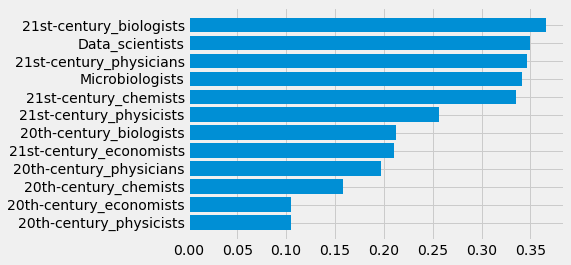

In [503]:
fig, ax = plt.subplots()
#could calculate variance and add error bars

ax.barh(x, y)


In [504]:
df_group_gender_cat = dfcsv.groupby(['category', 'female']).sum()

In [505]:
df_group_gender_cat['prop_phd'] = df_group_gender_cat['doctorate'] / df_group_gender_cat['here']

In [513]:
df_group_gender_cat = df_group_gender_cat.reset_index()

In [517]:

women_phd = df_group_gender_cat['prop_phd'][df_group_gender_cat['female'] == True]
men_phd = df_group_gender_cat['prop_phd'][df_group_gender_cat['female'] == False]

In [518]:
y_women  = women_phd
y_men = men_phd
x = df_group_cat['category']

In [523]:
fig, ax = plt.subplots()

N = len(x) 
ind = np.arange(N) 
width = 0.35       
ax.barh(ind, y_men, width, label='Men')
ax.barh(ind + width, y_women, width,
    label='Women')

plt.yticks(ind + width / 2, x)
plt.legend(loc='best')